## Edge Detection
Detect Signals in OAAM Functions Layer. Outputs polylines describing the connections. 

Conceptionally similar to scalable vertex detection. 

Tailored on the functions editor. Should be generalizable with medium effort. Expects vertical or horizontal line segments. Does not yet support crossings or other crossing solutions. Not tested for lines close to each other. Does not support diagonal lines, currently not a thing. Would be interesting with probabilistic Hough Trafo, but would probably need to subtract all other matches from the result. 

Maybe switch to template matching (with kind of same kernel/template). 

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import random as random
import math

### Input

In [4]:
# Define the paths
# target_image_path = 'screenshot-3-tasks.PNG'
# target_image_path = 'door_system.png'
# target_image_path = 'door_system_after_preprocessing_big_padding.png' # version 2 for paper with scaled vertex
# target_image_path = 'door_system_after_preprocessing_big.png' # for other images
# target_image_path = 'system.png'
# target_image_path = 'crossing.png'
target_image_path = 'multiplecrossings.png'

target_img = cv2.imread(target_image_path)

activate_plotly = False

### Visualization of Input
Grayscale is enough here. Kernel methods are not really for multi channel images.

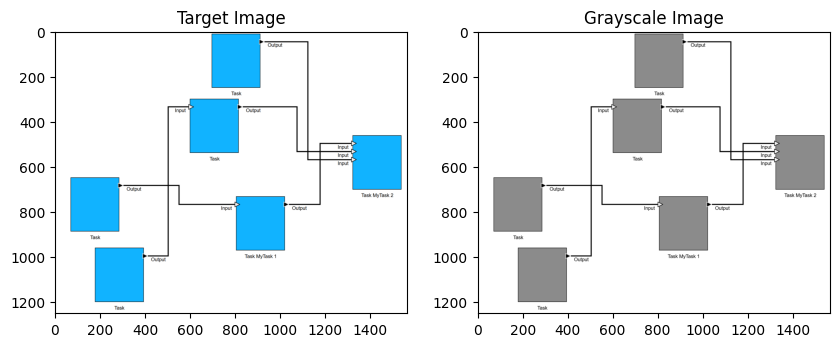

In [5]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
# Draw target image and grayscale image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Draw target image
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')

# Draw grayscale image
ax[1].imshow(target_gray, cmap='gray')
ax[1].set_title('Grayscale Image')

plt.show()

## Kernel / Custom Filter
Kernel Custom Line Detection and generation of intersection template image for later use

idea for later: search for many thicknesses of lines

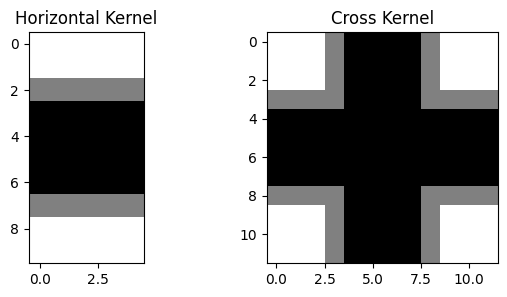

In [6]:
# Define custom kernels
kernel_vertical = np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (5, 1))
kernel_horizontal = np.transpose(kernel_vertical)

kernel_cross= np.ones((12, 12))

kernel_cross[3:9, 0:12] = 0.5  # Left vertical outline
kernel_cross[0:12, 3:9] = 0.5  # Right vertical outline

kernel_cross[4:8, 0:12] = 0  # Vertical part of the cross
kernel_cross[0:12, 4:8] = 0  # Horizontal part of the cross

# Draw the kernel
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(kernel_horizontal, cmap='gray')
ax[0].set_title('Horizontal Kernel')
ax[1].imshow(kernel_cross, cmap='gray')
ax[1].set_title('Cross Kernel')
plt.show()
# Save the cross kernel as a 10 by 10 pixel .png
# kernel_cross_resized = cv2.resize(kernel_cross, (10, 10), interpolation=cv2.INTER_NEAREST)
# cv2.imwrite('cross_kernel.png', (kernel_cross * 255).astype(np.uint8))

#### Applying custom filter to find vertical and horizontal edges
tried to find intersections this way as well, but it did not work

visualization of output at the end

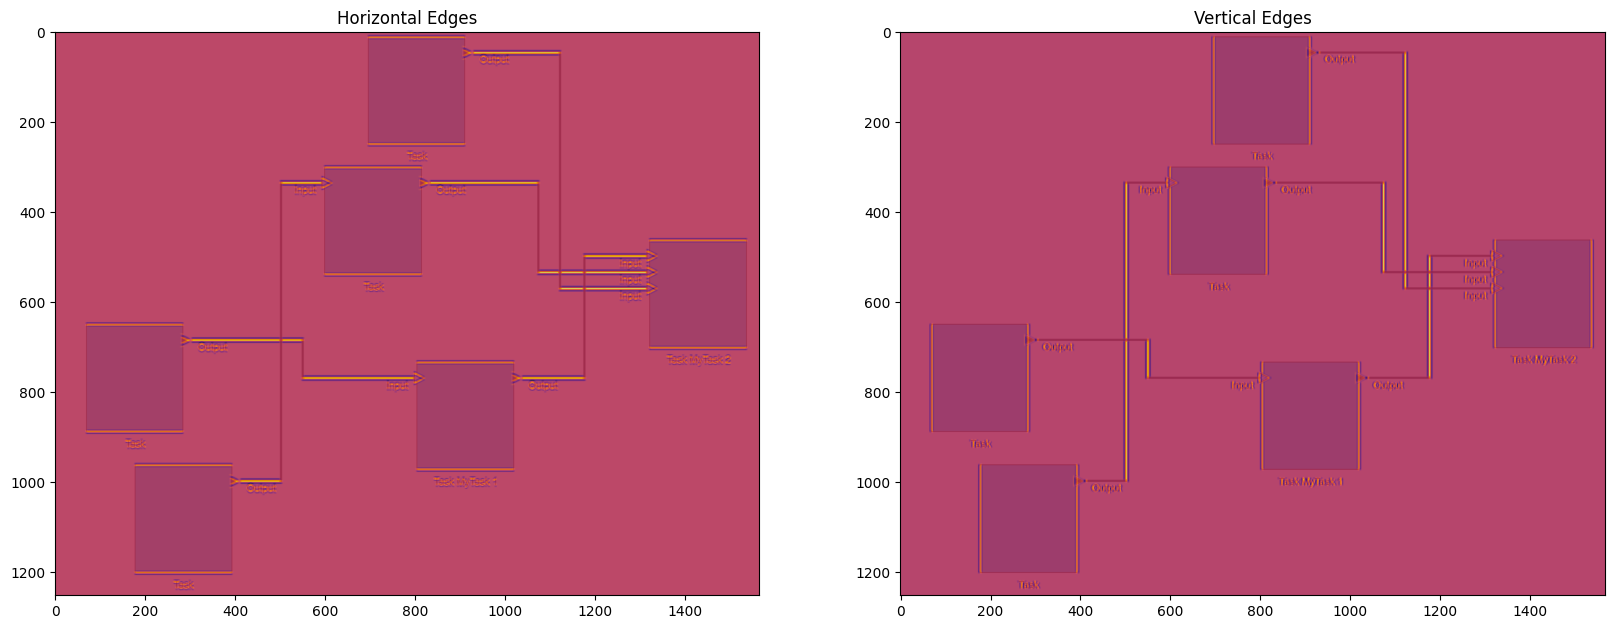

In [7]:
result_filter_ver = cv2.filter2D(target_gray, cv2.CV_32F, kernel_vertical)
result_filter_hor = cv2.filter2D(target_gray, cv2.CV_32F, kernel_horizontal)
# result_filter_crs = cv2.filter2D(target_gray, cv2.CV_32F, kernel_cross)

# Overlay both heatmaps on the target image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].imshow(result_filter_hor, cmap='inferno', alpha=0.9)
ax[0].set_title('Horizontal Edges')
ax[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[1].imshow(result_filter_ver, cmap='inferno', alpha=0.9)
ax[1].set_title('Vertical Edges')
plt.show()

#### Histogram

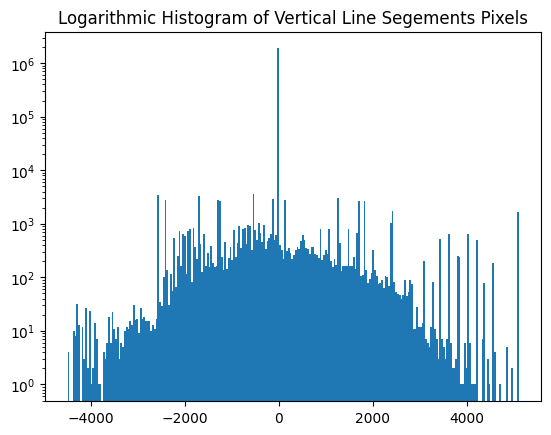

In [8]:
# Draw a logarithmic histogram of vertical edges
plt.hist(result_filter_ver.ravel(), bins=256, log=True)
plt.title('Logarithmic Histogram of Vertical Line Segements Pixels')
plt.show()

#### Visualization of Custom Filter 3D with plotly

In [9]:
if activate_plotly:
    # Create a 3D surface plot of the vertical edges
    fig = go.Figure(data=[go.Surface(z=result_filter_ver)])
    # fig = go.Figure(data=[go.Surface(z=result_filter_hor)])  # Horizontal edges
    fig.update_layout(
        title='3D Surface Plot of Vertical Edges',
        height=1500,
        scene=dict(
            yaxis = dict(autorange='reversed'),
            )
        )
    fig.show()

#### Visualization of Custom Filter 3D with plotly with screenshot for paper

In [10]:
template_matching_result = result_filter_hor.copy()

# target image
activate_plotly = False
if activate_plotly:
  fig = go.Figure()

  # Layer 1: 3D Plot of Heatmap
  fig.add_trace(go.Surface(
    z = template_matching_result,
    showscale = False
  ))

  # Layer 2: 2D Plot of Target Image at 1000
  z_image = np.ones_like(target_gray) * 1000
  fig.add_trace(go.Surface(
    z = z_image,
    showscale = False,
    # opacity = 0.5,
    surfacecolor = target_gray,
    colorscale = 'gray',
  ))

  fig.update_layout(title='Heatmap Custom Filter Vertical Edges', 
                    scene=dict(
                    yaxis=dict(autorange='reversed') 
                    ),
                    height=1500,
                    scene_aspectratio=dict(x=2, y=1, z=0.2),
                    )

  fig.show()

#### Normalizing to 8 Bit

In [11]:
# Normalize to 0-255 and convert to uint8
result_filter_ver_norm = cv2.normalize(result_filter_ver, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
result_filter_hor_norm = cv2.normalize(result_filter_hor, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

#### Check Histogram
histogram looks like above, but with other scale -> what we want

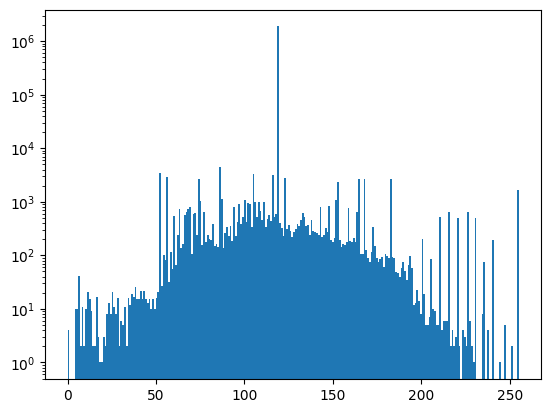

In [12]:
# plot the histogram of the normalized vertical edges, log scale
plt.hist(result_filter_ver_norm.ravel(), 256, log=True)
plt.show()

#### Thresholding and visualization

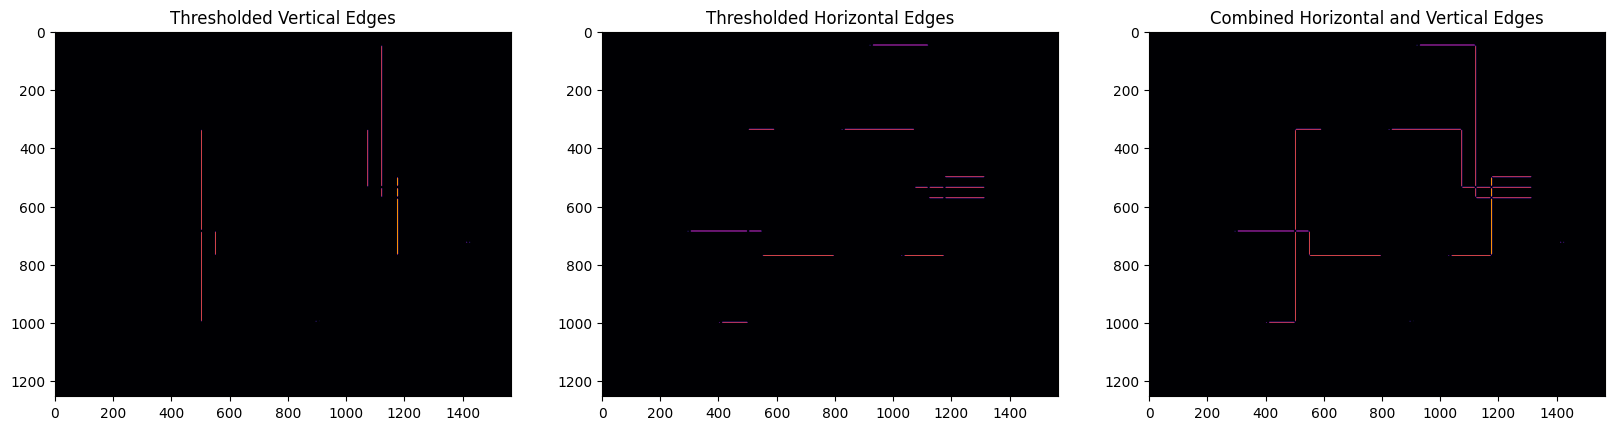

In [13]:
threshold = 220
_, result_filter_ver_thresh = cv2.threshold(result_filter_ver_norm, threshold, 255, cv2.THRESH_BINARY)
_, result_filter_hor_thresh = cv2.threshold(result_filter_hor_norm, threshold, 255, cv2.THRESH_BINARY)

hv_edges_thresh = result_filter_ver_thresh + result_filter_hor_thresh
# Draw the thresholded images and histogram next to each other
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# Thresholded Vertical Edges
ax[0].imshow(result_filter_ver_thresh, cmap='inferno')
ax[0].set_title('Thresholded Vertical Edges')

# Thresholded Horizontal Edges
ax[1].imshow(result_filter_hor_thresh, cmap='inferno')
ax[1].set_title('Thresholded Horizontal Edges')

# Combined Horizontal and Vertical Edges
ax[2].imshow(hv_edges_thresh, cmap='inferno')
ax[2].set_title('Combined Horizontal and Vertical Edges')

# Logarithmic Histogram of Thresholded Vertical Edges
# ax[1, 1].hist(result_filter_ver_thresh.ravel(), bins=256, log=True)
# ax[1, 1].set_title('Logarithmic Histogram of Thresholded Vertical Edges')

plt.show()


### From Pixels to Contours
Group Pixels to Contours and draw them onto the target image

Found 19 horizontal contours, and 13 vertical contours


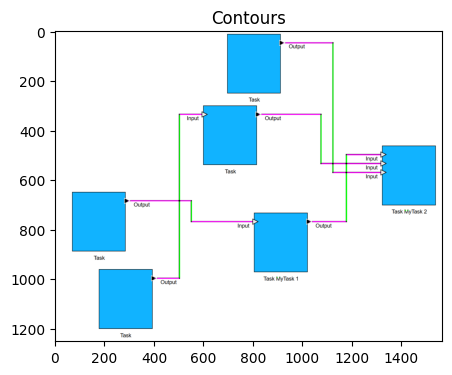

In [14]:
# Find contours
contours_hor, _ = cv2.findContours(result_filter_hor_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_ver, _ = cv2.findContours(result_filter_ver_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Found {len(contours_hor)} horizontal contours, and {len(contours_ver)} vertical contours')

# Draw the contours. Horizontal in blue, vertical in green
contour_img_all = target_img.copy()
# Convert contours to the correct format
contours_hor = [np.array(contour, dtype=np.int32) for contour in contours_hor]
contours_ver = [np.array(contour, dtype=np.int32) for contour in contours_ver]

# Draw contours
cv2.drawContours(contour_img_all, contours_hor, -1, (255, 0, 255), 2)
cv2.drawContours(contour_img_all, contours_ver, -1, (0, 255, 0), 2)

# Plot the contours
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(contour_img_all, cv2.COLOR_BGR2RGB))
ax.set_title('Contours')
plt.show()

#### Filter out very short Contours
thes are mainly false positives, for example at the ports or the characters.
They are very hard to see.

In [15]:
# Filter out very short contours
min_contour_length = 20
contours_hor_filtered = [c for c in contours_hor if cv2.arcLength(c, False) > min_contour_length]
contours_ver_filtered = [c for c in contours_ver if cv2.arcLength(c, False) > min_contour_length]
print(f'After filtering, found {len(contours_hor_filtered)} horizontal contours, and {len(contours_ver_filtered)} vertical contours.')
print(f'Filtered out {len(contours_hor) - len(contours_hor_filtered)} horizontal contours, and {len(contours_ver) - len(contours_ver_filtered)} vertical contours.')

# Print the points of the filtered contours
# for i, contour in enumerate(contours_hor_filtered):
#     print(f"Horizontal contour {i}: {contour.squeeze().tolist()}")
# for i, contour in enumerate(contours_ver_filtered):
#     print(f"Vertical contour {i}: {contour.squeeze().tolist()}")

After filtering, found 14 horizontal contours, and 9 vertical contours.
Filtered out 5 horizontal contours, and 4 vertical contours.


#### From Contours to Line Segments
Contours are areas (but very line segment looking). So they are approximated to line segments.

In [16]:
def vertical_contours_to_vertical_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the vertical extents by finding min and max y coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        y1, y2 = np.min(y_coords), np.max(y_coords)
        x = np.mean(x_coords).astype(int)  # Assuming vertical, x should be constant
        
        lines.append(((x, y1), (x, y2)))
    
    return lines

def horizontal_contours_to_horizontal_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the horizontal extents by finding min and max x coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        x1, x2 = np.min(x_coords), np.max(x_coords)
        y = np.mean(y_coords).astype(int)  # Assuming horizontal, y should be constant
        
        lines.append(((x1, y), (x2, y)))
    
    return lines

line_segments_ver = vertical_contours_to_vertical_segments(contours_ver_filtered)
line_segments_hor = horizontal_contours_to_horizontal_segments(contours_hor_filtered)

#### Visualize the Line Segments and highlight the points

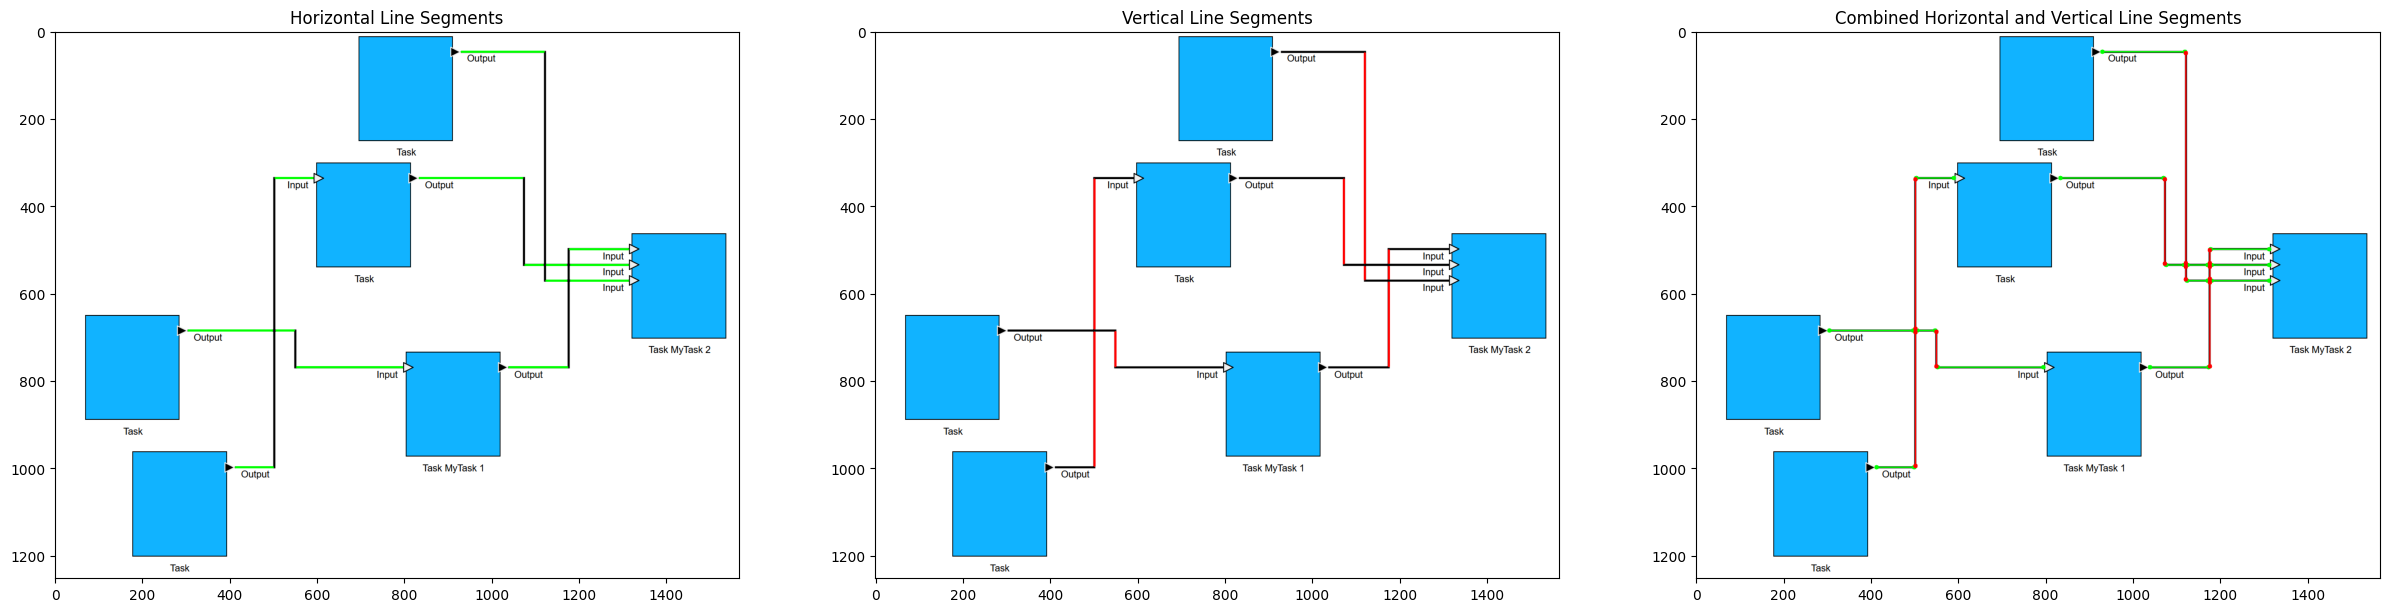

Vertical line segment 0: Start: (502, 689), End: (502, 995)
Vertical line segment 1: Start: (550, 688), End: (550, 767)
Vertical line segment 2: Start: (1176, 575), End: (1176, 767)
Vertical line segment 3: Start: (1176, 539), End: (1176, 567)
Vertical line segment 4: Start: (1121, 539), End: (1121, 568)
Vertical line segment 5: Start: (1176, 501), End: (1176, 531)
Vertical line segment 6: Start: (1073, 339), End: (1073, 532)
Vertical line segment 7: Start: (502, 339), End: (502, 681)
Vertical line segment 8: Start: (1121, 50), End: (1121, 531)

Horizontal line segment 0: Start: (413, 998), End: (499, 998)
Horizontal line segment 1: Start: (1039, 769), End: (1173, 769)
Horizontal line segment 2: Start: (553, 769), End: (795, 769)
Horizontal line segment 3: Start: (506, 685), End: (547, 685)
Horizontal line segment 4: Start: (305, 685), End: (497, 685)
Horizontal line segment 5: Start: (1180, 571), End: (1312, 571)
Horizontal line segment 6: Start: (1124, 571), End: (1171, 571)
Horizont

In [17]:
# Draw the horizontal lines
edges_hor_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_hor_img, line[0], line[1], (0, 255, 0), 4)

# Draw the vertical lines
edges_ver_img = target_img.copy()
for line in line_segments_ver:
    cv2.line(edges_ver_img, line[0], line[1], (0, 0, 255), 4)

# Draw the combined lines
edges_combined_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_combined_img, line[0], line[1], (0, 255, 0), 2)
    cv2.circle(edges_combined_img, line[0], 5, (0, 255, 0), -1)
    cv2.circle(edges_combined_img, line[1], 5, (0, 255, 0), -1)
for line in line_segments_ver:
    cv2.line(edges_combined_img, line[0], line[1], (0, 0, 255), 2)
    cv2.circle(edges_combined_img, line[0], 5, (0, 0, 255), -1)
    cv2.circle(edges_combined_img, line[1], 5, (0, 0, 255), -1)

# Create a single figure with three subplots (1 row, 3 columns)
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# Plot the horizontal lines in the first subplot
ax[0].imshow(cv2.cvtColor(edges_hor_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Horizontal Line Segments')

# Plot the vertical lines in the second subplot
ax[1].imshow(cv2.cvtColor(edges_ver_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Vertical Line Segments')

# Plot the combined lines in the third subplot
ax[2].imshow(cv2.cvtColor(edges_combined_img, cv2.COLOR_BGR2RGB))
ax[2].set_title('Combined Horizontal and Vertical Line Segments')

plt.show()

# Print all vertical line segments
for i, ver_line in enumerate(line_segments_ver):
    print(f"Vertical line segment {i}: Start: ({ver_line[0][0]}, {ver_line[0][1]}), End: ({ver_line[1][0]}, {ver_line[1][1]})")
print()
# Print all horizontal line segments
for i, hor_line in enumerate(line_segments_hor):
    print(f"Horizontal line segment {i}: Start: ({hor_line[0][0]}, {hor_line[0][1]}), End: ({hor_line[1][0]}, {hor_line[1][1]})")

#### sort the line segments
Not only line segments are needed, but connected line segments that form a polygonal chain. The problem is that the line segments do not touch each other, leaving a small gap. The concept is to chain the segments together. Currently, this only supports horizontally starting signals, which is always the case for the Functions Layer, but this needs to be expanded in the future.

In [18]:
# Sort horizontal segments from left to right and vertical segments from top to bottom
# Separated vertical and horizontal segments
line_segments_hor_sorted = line_segments_hor.copy()
line_segments_hor_sorted.sort(key=lambda seg: (seg[0][0], seg[0][1]))
line_segments_ver_sorted = line_segments_ver.copy()
line_segments_ver_sorted.sort(key=lambda seg: (seg[0][1], seg[0][0]))

#### finding and handeling intersections
Template matching is used to locate intersections. They are processed first and then added to the rest of the line segments.

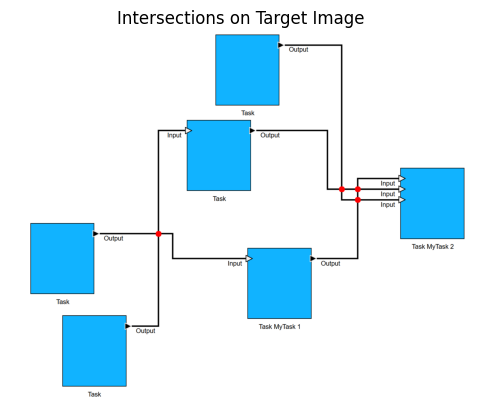

Intersection at: (1122, 535)
Intersection at: (1176, 535)
Intersection at: (1176, 571)
Intersection at: (502, 686)


In [19]:
# finding intersections
intersections_on_target_img = target_img.copy()
intersection_img = cv2.imread('cross_kernel.png')
res = cv2.matchTemplate(target_img, intersection_img, cv2.TM_CCOEFF_NORMED)

# Threshold the result
threshold = 0.95 # 0.92 or lower results in multiple matches per crossing
loc = np.where(res >= threshold)

# Move the detected crosses 6 pixels to the right and 6 pixels down so the intersections match the center of the cross
# (12 by 12 template)
loc = (loc[0] + 6, loc[1] + 6)

# Print the coordinates of the found intersections
for pt in zip(*loc[::-1]):
    cv2.circle(intersections_on_target_img, pt, 10, (0, 0, 255), -1)

# Display the image with intersections
plt.imshow(cv2.cvtColor(intersections_on_target_img, cv2.COLOR_BGR2RGB))
plt.title('Intersections on Target Image')
plt.axis('off')
plt.show()

for pt in zip(*loc[::-1]):
    print(f"Intersection at: ({int(pt[0])}, {int(pt[1])})")

### connecting intersections
At each intersection, the lines corresponding to the four nearest points are connected.

In [20]:
def find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted):
    x, y = crossing
    closest_ver = sorted(line_segments_ver_sorted, key=lambda seg: min(abs(seg[0][0] - x), abs(seg[1][0] - x)))[:2]
    closest_hor = sorted(line_segments_hor_sorted, key=lambda seg: min(abs(seg[0][1] - y), abs(seg[1][1] - y)))[:2]
    return closest_ver, closest_hor

def merge_lines(closest_ver, closest_hor):
    merged_ver = (min(closest_ver[0][0][1], closest_ver[1][0][1]), max(closest_ver[0][1][1], closest_ver[1][1][1]))
    merged_hor = (min(closest_hor[0][0][0], closest_hor[1][0][0]), max(closest_hor[0][1][0], closest_hor[1][1][0]))
    return merged_ver, merged_hor

def connect_lines_at_crossings(crossings, line_segments_ver_sorted, line_segments_hor_sorted):
    merged_lines = []
    for crossing in crossings:
        closest_ver, closest_hor = find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted)
        
        merged_ver, merged_hor = merge_lines(closest_ver, closest_hor)
        
        for line in closest_ver:
            line_segments_ver_sorted.remove(line)
        for line in closest_hor:
            line_segments_hor_sorted.remove(line)
        
        new_ver_line = ((crossing[0], merged_ver[0]), (crossing[0], merged_ver[1]))
        new_hor_line = ((merged_hor[0], crossing[1]), (merged_hor[1], crossing[1]))
        
        line_segments_ver_sorted.append(new_ver_line)
        line_segments_hor_sorted.append(new_hor_line)
        
        merged_lines.append((new_ver_line, new_hor_line))
    
    return line_segments_ver_sorted, line_segments_hor_sorted, merged_lines

line_segments_ver_sorted, line_segments_hor_sorted, merged_lines = connect_lines_at_crossings(zip(*loc[::-1]), line_segments_ver_sorted, line_segments_hor_sorted)

#### visualize the line segments

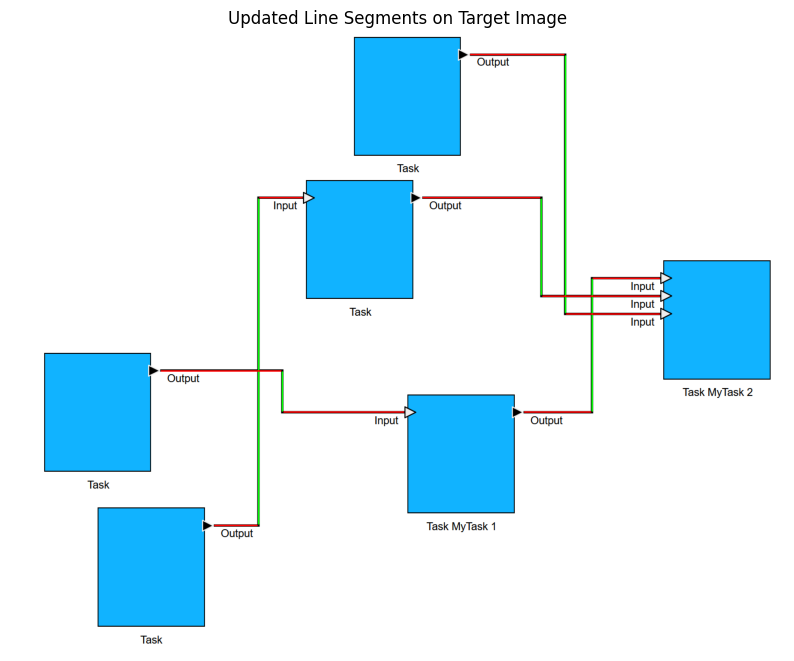

Total number of vertical line segments: 5
Total number of horizontal line segments: 10


In [21]:
# Draw the updated vertical and horizontal line segments on the target image
target_img_with_merged_lines = target_img.copy()
for line in line_segments_ver_sorted:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 255, 0), 2)
for line in line_segments_hor_sorted:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 0, 255), 2)

# Display the image with updated line segments
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_merged_lines, cv2.COLOR_BGR2RGB))
plt.title('Updated Line Segments on Target Image')
plt.axis('off')
plt.show()
print(f"Total number of vertical line segments: {len(line_segments_ver_sorted)}")
print(f"Total number of horizontal line segments: {len(line_segments_hor_sorted)}")

## Chain the line segments together
It starts with the leftest horizontal line segment and walks its way to the end of the edge what the polygonal chain. Currently this does not support starting with a vertical line segment. This needs to be generalized in future. For example it might use some heuristics to check that it is not an intermediate line segment, but a starting or ending line segment of a chain.

Take the leftest horizontal segment. Search for closest starting/ending points of vertical segment. Store, which segments are used. Continue alternativ vertical/horizontal. Finish polygonal chain if no starting/ending point within a distance of 7.

The generated chains have gaps between segments, which need to be closed before they can be converted to polylines

In [22]:
def calculate_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

def find_closest_segment(base_segment, candidate_segments, max_distance=7):
    """Find the closest segment from candidate_segments to either the start or end point of the base_segment. But only to a maximum distance of max_distance."""
    closest_segment = None
    closest_distance = max_distance + 1  # Initialize with a value slightly larger than max_distance

    # Check both the start and end points of the base segment
    for base_point in [base_segment[0], base_segment[1]]:
        for seg in candidate_segments:
            # Check both start and end points of the candidate segment
            for point in [seg[0], seg[1]]:
                distance = calculate_distance(base_point, point)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_segment = seg

    return closest_segment if closest_distance <= max_distance else None

def group_segments_into_chains(h_segments, v_segments, max_distance=7):
    chains = []
    used_segments = set()

    # Function to add segments to 'used_segments' and remove them from 'h_segments' or 'v_segments'
    def mark_used(seg):
        if seg in h_segments:
            h_segments.remove(seg)
        elif seg in v_segments:
            v_segments.remove(seg)
        used_segments.add(seg)

    # Start with horizontal segments as potential starting points
    for h_seg in list(h_segments):  # Use list(...) to avoid modifying the list while iterating
        if h_seg in used_segments:
            continue
        current_chain = [h_seg]  # chain starts with a horizontal segment
        mark_used(h_seg)

        # Alternate between finding vertical and horizontal segments to connect
        searching_for = 'vertical'
        while True:
            if searching_for == 'vertical':
                next_seg = find_closest_segment(current_chain[-1], v_segments, max_distance)
                if next_seg:
                    current_chain.append(next_seg)
                    mark_used(next_seg)
                    searching_for = 'horizontal'  # Switch to searching for the next horizontal segment
                else:
                    break  # No more segments to connect
            else:
                next_seg = find_closest_segment(current_chain[-1], h_segments, max_distance)
                if next_seg:
                    current_chain.append(next_seg)
                    mark_used(next_seg)
                    searching_for = 'vertical'
                else:
                    break

        chains.append(current_chain)

    return chains

line_segment_chains = group_segments_into_chains(line_segments_hor_sorted.copy(), line_segments_ver_sorted.copy())

# Sort the lines inside each chain in order of position from left to right
sorted_line_segment_chains = []
for chain in line_segment_chains:
    sorted_chain = sorted(chain, key=lambda seg: (seg[0][0], seg[1][0]))
    sorted_line_segment_chains.append(sorted_chain)
line_segment_chains = sorted_line_segment_chains

#### visualizing the chains

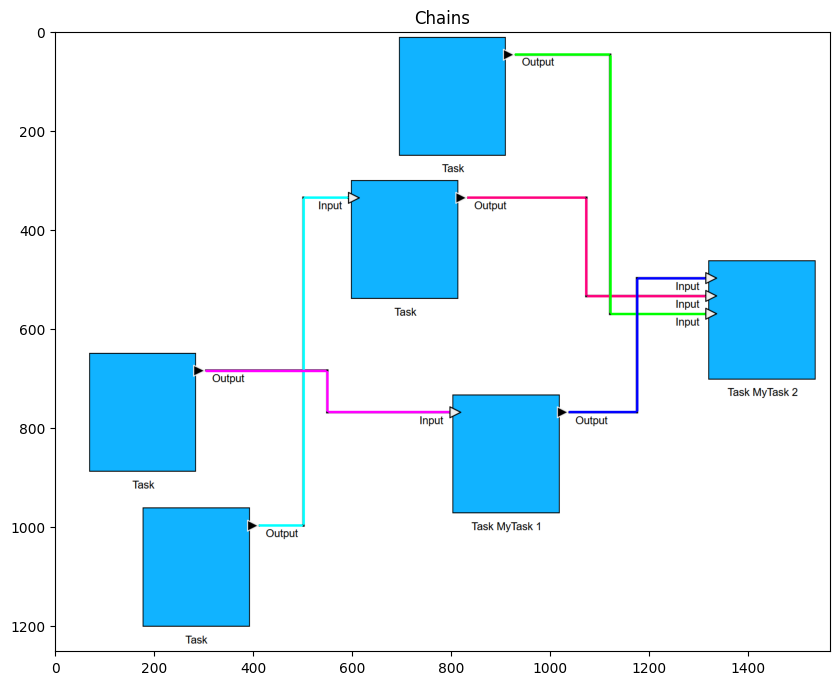

In [23]:
# Draw the chains, using different colors for each chain
chain_img = target_img.copy()
colors = [(255, 255, 0), (255, 0, 255), (125, 0, 255),  (0, 255, 0), (255, 0, 0), (0, 0, 255), (128, 128, 128), (128, 0, 128), (0, 128, 128), (128, 128, 0), (0, 128, 0), (255, 105, 180), (139, 69, 19)]

for i, chain in enumerate(line_segment_chains):
    color = colors[i % len(colors)]
    for start, end in chain:
        cv2.line(chain_img, start, end, color, 4)

# Plot the chains
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(chain_img, cv2.COLOR_BGR2RGB))
plt.title('Chains')
plt.show()

### From Chains to Polylines

In [27]:
def calculate_intersection(seg1, seg2):
    """
    Calculate the intersection point of two line segments.
    Very generic, does not assume that the segments are orthogonal.

    Parameters:
    - seg1, seg2: The line segments, each represented as a tuple of points ((x1, y1), (x2, y2)).

    Returns:
    - The intersection point (x, y) as a tuple, or None if the segments do not intersect.
    """
    # Unpack points
    x1, y1, x2, y2 = seg1[0][0], seg1[0][1], seg1[1][0], seg1[1][1]
    x3, y3, x4, y4 = seg2[0][0], seg2[0][1], seg2[1][0], seg2[1][1]

    # Calculate denominators
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    # Check if lines are parallel (denominator = 0)
    if den == 0:
        return None  # Lines are parallel and do not intersect

    # Calculate numerators
    t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)

    # Calculate the intersection point
    t = t_num / den
    intersect_x = x1 + t * (x2 - x1)
    intersect_y = y1 + t * (y2 - y1)
    
    return (intersect_x, intersect_y)

def construct_polylines(chains):
    """
    Constructs polylines from chains of line segments, using intersection points between
    consecutive orthogonal segments to form a continuous path.

    Parameters:
    - chains: A list of chains, where each chain is a list of segments ordered such that
      each segment is orthogonal to the next.

    Returns:
    - A list of polylines, where each polyline is represented as an ordered list of points.
    """
    polylines = []

    for chain in chains:
        if not chain:
            continue  # Skip empty chains

        # Start the polyline with the start point of the first segment
        polyline = [chain[0][0]]

        for i in range(len(chain) - 1):
            # Calculate the intersection point between the current segment and the next
            intersection = calculate_intersection(chain[i], chain[i + 1])
            if intersection:
                polyline.append(intersection)

        # Add the end point of the last segment in the chain
        polyline.append(chain[-1][1])

        polylines.append(polyline)

    return polylines

polylines = construct_polylines(line_segment_chains)
# Printing the constructed polylines
for i, polyline in enumerate(polylines):
    formatted_points = ', '.join([f"({int(point[0])}, {int(point[1])})" for point in polyline])
    print(f"Polyline {i}: [{formatted_points}]")

Polyline 0: [(413, 998), (502, 998), (502, 336), (590, 336)]
Polyline 1: [(305, 686), (550, 686), (550, 769), (795, 769)]
Polyline 2: [(834, 336), (1073, 336), (1073, 535), (1312, 535)]
Polyline 3: [(930, 47), (1122, 47), (1122, 571), (1312, 571)]
Polyline 4: [(1039, 769), (1176, 769), (1176, 499), (1312, 499)]


#### Visualize Polylines

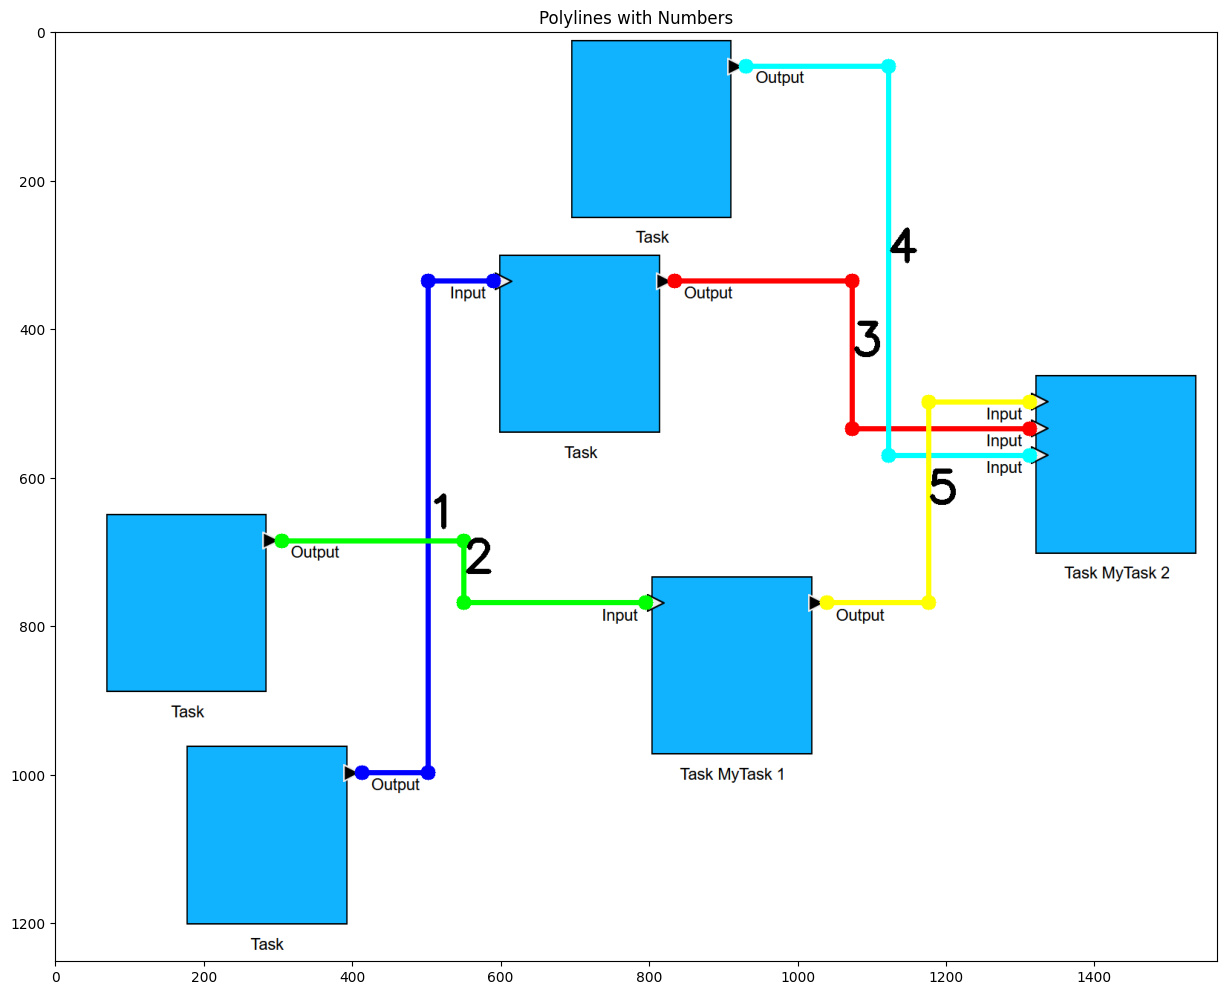

In [26]:
# Filter out None values and convert to integer tuples
filtered_polylines = []
for polyline in polylines:
    filtered_polyline = [point for point in polyline if point is not None]
    filtered_polylines.append(filtered_polyline)

# Convert the polylines to the format expected by OpenCV
opencv_polylines = [np.array(polyline, dtype=np.int32).reshape((-1, 1, 2)) for polyline in filtered_polylines]

# Define colors for the polylines
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

# Draw the polylines
polyline_img = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(polyline_img, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(polyline_img, tuple(point.squeeze()), 10, color, -1)
        # Draw the lines on the target_img.copy()
        target_img_with_polylines = target_img.copy()
        for i, polyline in enumerate(opencv_polylines):
            color = colors[i % len(colors)]
            cv2.polylines(target_img_with_polylines, [polyline], isClosed=False, color=color, thickness=6)
            for point in polyline:
                cv2.circle(target_img_with_polylines, tuple(point.squeeze()), 10, color, -1)

# Print the number of each polyline on the image
for i, polyline in enumerate(opencv_polylines):
    # Calculate the center of the polyline for placing the text
    center_x = int(np.mean(polyline[:, 0, 0]))
    center_y = int(np.mean(polyline[:, 0, 1]))
    cv2.putText(target_img_with_polylines, str(i + 1), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)

# Plot the polylines with numbers
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
plt.title('Polylines with Numbers')
plt.show()